In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

## Load Datasets

In [4]:
iris_datasets = load_iris()
X_iris, y_iris = iris_datasets.data[:-1, :], iris_datasets.target[:-1]
y_iris = pd.get_dummies(y_iris).values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.33, random_state=90)

## Set Placeholders

In [6]:
num_features = X_train.shape[1] # in the iris dataset, this number is 4
num_labels = y_train.shape[1] # and this number is 3

In [7]:
X = tf.placeholder(tf.float32, [None, num_features]) # iris has 4 features, so X is a tensor to hold our data
y = tf.placeholder(tf.float32, [None, num_labels]) # y is a tensor to hold matrix for 3 classes

## Set Variable

In [8]:
# randomly sample from a normal distribution with standard deviation .01
weights = tf.Variable(tf.random_normal([num_features, num_labels], mean=0, stddev=0.01, name='weights'))
bias = tf.Variable(tf.random_normal([1, num_labels], mean=0, stddev=0.01, name='bias'))

## Set Operation

In [9]:
# three-component breakdown of the Logistic Regression equation
apply_weights_op = tf.matmul(X, weights, name='apply_weights')
add_bias_op = tf.add(apply_weights_op, bias, name='add_bias')
activation_op = tf.nn.sigmoid(add_bias_op, name='activation')

## Set Loss Function

In [10]:
loss_op = tf.nn.l2_loss(activation_op - y, name='squared_error_loss')

## Set Optimizer

In [11]:
# defining learning rate iteration with decay
learning_rate = tf.train.exponential_decay(learning_rate=8e-4, global_step=1, 
                                           decay_steps=X_train.shape[0], decay_rate=0.95, staircase=True)

In [12]:
# defining Gradient Descent
optimizer_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_op)

## Train The Graph

In [13]:
init_op = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    sess.run(init_op) # initialize the variables before executing a graph
    
    # operation for tracking our model
    correct_prediction_op = tf.equal(tf.argmax(activation_op, 1), tf.argmax(y, 1))

    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction_op, 'float'))

    activation_summary_op = tf.summary.histogram('output', activation_op)

    accuracy_summary_op = tf.summary.scalar('accuracy', accuracy_op)

    loss_summary_op = tf.summary.scalar('loss', loss_op)
    
    weight_summary = tf.summary.histogram('weights', weights.eval(session=sess))
    bias_summary = tf.summary.histogram('biases', bias.eval(session=sess))
    
    all_summary = tf.summary.merge([activation_summary_op, accuracy_summary_op, loss_summary_op, weight_summary, bias_summary])
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    # initialize reporting variables
    loss = 0
    diff = 1
    epoch_values = []
    accuracy_values = []
    loss_values = []
    num_epochs = 400
    
    for i_epoch in range(1, num_epochs+1):
        
        if i_epoch > 1 and diff < .0001:
            print(f'Change in loss {diff}, convergence.')
            break
        else:
            
            # run training step
            step = sess.run(optimizer_op, feed_dict={X: X_train, y: y_train})
                        
            # add epoch to epoch values
            epoch_values.append(i_epoch)

            # generate accuracy stats on test data
            train_accuracy, new_loss = sess.run([accuracy_op, loss_op], feed_dict={X: X_train, y: y_train})

            # add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)

            # add cost to live graphing variable
            loss_values.append(new_loss)

            # re-assign values for variables
            diff = abs(new_loss - loss)
            loss = new_loss
            
            # report occasional stats
            if i_epoch % 10 == 0:    
                # generate print statements
                print(f'Epoch {i_epoch}, Training accuracy: {train_accuracy:.6f}, Loss: {new_loss:.6f}, Loss diff: {diff:.6f}')
                
    # check how well do the model perform held-out test data
    final_accuracy = sess.run(accuracy_op, feed_dict={X: X_test, y: y_test})
    print(f'\nFinal accuracy on test set: {final_accuracy:.6f}')

Epoch 10, Training accuracy: 0.585859, Loss: 30.234148, Loss diff: 0.232765
Epoch 20, Training accuracy: 0.717172, Loss: 28.138403, Loss diff: 0.193720
Epoch 30, Training accuracy: 0.919192, Loss: 26.384912, Loss diff: 0.160746
Epoch 40, Training accuracy: 0.979798, Loss: 24.940121, Loss diff: 0.131924
Epoch 50, Training accuracy: 0.959596, Loss: 23.755274, Loss diff: 0.108259
Epoch 60, Training accuracy: 0.949495, Loss: 22.780106, Loss diff: 0.089392
Epoch 70, Training accuracy: 0.919192, Loss: 21.970980, Loss diff: 0.074509
Epoch 80, Training accuracy: 0.919192, Loss: 21.292690, Loss diff: 0.062780
Epoch 90, Training accuracy: 0.919192, Loss: 20.717772, Loss diff: 0.053486
Epoch 100, Training accuracy: 0.919192, Loss: 20.225044, Loss diff: 0.046074
Epoch 110, Training accuracy: 0.919192, Loss: 19.798237, Loss diff: 0.040096
Epoch 120, Training accuracy: 0.919192, Loss: 19.424789, Loss diff: 0.035242
Epoch 130, Training accuracy: 0.939394, Loss: 19.094961, Loss diff: 0.031248
Epoch 14

## Plot Loss

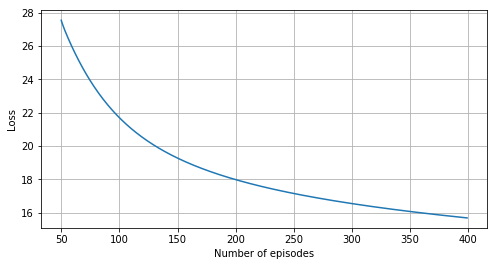

In [15]:
plt.plot([np.mean(loss_values[i-50:i]) for i in range(len(loss_values))])
plt.xlabel('Number of episodes')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

---